30 by 30 Analysis
===

## Setup

In [1]:
# Import packages
from pathlib import Path
import pandas as pd
import geopandas as gpd
import json
from modelmw_client import *
from IPython.display import clear_output
import csv
from shapely.validation import make_valid
from shapely.geometry import shape, MultiPolygon, LineString, MultiLineString

# Plotting packages
import matplotlib.pyplot as plt

## File paths

In [2]:
# Find your current working directory, which should be folder for this notebook.
Path.cwd()

WindowsPath('C:/Users/clulay/OneDrive - LimnoTech/Documents/GitHub/pollution-assessment/stage2/Protected_Lands')

In [3]:
# Set your project directory to your local folder for your clone of this repository
project_path = Path.cwd().parent.parent
project_path

WindowsPath('C:/Users/clulay/OneDrive - LimnoTech/Documents/GitHub/pollution-assessment')

In [4]:
# Path to WeConservePA protected lands shapefile
wcpa_path = project_path / Path('stage2/Protected_Lands/WeConservePA_pl_20220810.shp')
wcpa_path.exists()

True

## Private file paths
- Download from https://drive.google.com/drive/folders/1HKlnA3lC2xvKBQ1bg1J08gsEB3N9rp2V
- Save in `stage2/private` folder

In [5]:
# Path to FieldDoc protected lands export file
fielddoc_path = project_path / Path('stage2/private/protection_bmps_from_FieldDoc.parquet')
fielddoc_path.exists()

True

# Load data

## Protected Lands from WeConservePA

In [6]:
# Import weconservePA protected lands
wcpa_gdf = gpd.read_file(wcpa_path)

In [7]:
# Add data source tag
wcpa_gdf['data_source'] = 'weconservePA_2022'

## Protected Lands from FieldDoc

In [8]:
# Import FieldDoc protected lands 
fielddoc_gdf = gpd.read_parquet(fielddoc_path)

# Add a column to fielddoc_gdf with data source
fielddoc_gdf['data_source'] = 'fielddoc_2022-08-11'

## DRWI Geographies

In [9]:
# Import cluster and focus area geometries
cluster_gdf = gpd.read_parquet(project_path / Path('stage1/data/cluster_df.parquet'))  
focusarea_gdf = gpd.read_parquet(project_path / Path('stage1/data/fa_phase2_df.parquet'))

focusarea_gdf.cluster = focusarea_gdf.cluster.replace('Kirkwood Cohansey Aquifer', 'Kirkwood - Cohansey Aquifer') # update name for consistency with other files 
focusarea_gdf.set_index('name', inplace=True)

## HUC12s

In [10]:
huc12 = pd.read_csv(project_path / Path('stage2/DRB_GWLFE/geojson/huc12_list_drwipolassess.csv'))
huc12 = huc12.astype({'huc12': str})

# Add leading zeros so hucs ids are 12 digits long
huc12['huc12'] = huc12['huc12'].apply(lambda x: x.zfill(12))
huc12_list = huc12['huc12'].to_list()

huc12_list_short = huc12_list[0:3]
huc12_list_short

['020401010101', '020401010102', '020401010103']

In [11]:
#huc12_lu_df = mmw_run.run_batch_analysis(huc12_list_short,
            #mmw_run.land_endpoint.format("2019_2019"))

# Transform projections
All data needs to be in lat/long projection to be understood by MMW.

In [12]:
# Latest fielddoc export has no attached projection
# Set fielddoc projection to the original fielddoc export projection 
fielddoc_gdf = fielddoc_gdf.set_crs(epsg=4326, inplace=True, allow_override=True)

In [13]:
wcpa_gdf.to_crs(epsg=4326, inplace=True)
cluster_gdf.to_crs(epsg=4326, inplace=True)
focusarea_gdf.to_crs(epsg=4326, inplace=True)

# Fix geometries that are not a singular closed loop

In [22]:
muddyrun_gdf = focusarea_gdf[focusarea_gdf.index=='Muddy Run']
explode_fa_gdf = muddyrun_gdf.explode()
explode_fa_gdf

C:\Users\clulay\AppData\Local\Temp\ipykernel_10564\4109479401.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  explode_fa_gdf = muddyrun_gdf.explode()


cluster strategy   nord    phase change  \
name                                                                       
Muddy Run 0  Kirkwood - Cohansey Aquifer   hybrid  15092  Phase 2   None   
          1  Kirkwood - Cohansey Aquifer   hybrid  15092  Phase 2   None   

             tier subfocusare  area_acres name_final  \
name                                                   
Muddy Run 0  None        None   8887.9498  Muddy Run   
          1  None        None   8887.9498  Muddy Run   

                                                     geom_buff  \
name                                                             
Muddy Run 0  01060000206A7F00000200000001030000000100000094...   
          1  01060000206A7F00000200000001030000000100000094...   

                                                          geom  
name                                                            
Muddy Run 0  POLYGON ((-75.13781 39.55753, -75.13732 39.555...  
          1  POLYGON ((-75.18030 39.58255, -75.18030 39.582...

<AxesSubplot:>

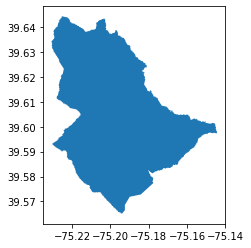

In [24]:
x = explode_fa_gdf[1:2]
x
x.plot()

In [26]:
# Muddy Run 
#explode_fa_gdf_valid = explode_fa_gdf[explode_fa_gdf['geom'].type != 'LineString']
#explode_fa_gdf_valid
#MR_gdf = explode_fa_gdf_valid.explode()

In [25]:
explode_fa_gdf.to_file(project_path / Path('stage2/Protected_Lands/muddyrun.geojson'), driver="GeoJSON")
MR_json = json.load(open(project_path / Path('stage2/Protected_Lands/muddyrun.geojson')))

# Save geometries to geojsons

In [27]:
# JSON cannot interpret categorical datatype. Convert all categorical to object
cluster_gdf = cluster_gdf.reset_index()
cluster_gdf = cluster_gdf.astype({'name': object, 'labels': object})

In [79]:
wcpa_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22137 entries, 0 to 22136
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   OBJECTID     22137 non-null  int64   
 1   Category     22137 non-null  object  
 2   sitename     21956 non-null  object  
 3   esmthldr     8877 non-null   object  
 4   eholdtype    8868 non-null   object  
 5   own_name     13258 non-null  object  
 6   own_type     18637 non-null  object  
 7   URL          20702 non-null  object  
 8   purpose      18507 non-null  object  
 9   year_est     22137 non-null  int64   
 10  gis_acres    22137 non-null  float64 
 11  pubaccess    22015 non-null  object  
 12  Landscape    911 non-null    object  
 13  Cluster      9355 non-null   object  
 14  LTSA         22115 non-null  object  
 15  WTRSA        18649 non-null  object  
 16  State_abb    22127 non-null  object  
 17  State        22127 non-null  object  
 18  County       22127

In [80]:
# Subset wcpa into 5 separate files bc api capacity is 5000 calls/day
wcpa_1 = wcpa_gdf[0:4999]
wcpa_2 = wcpa_gdf[4999:9999]
wcpa_3 = wcpa_gdf[9999:14999]
wcpa_4 = wcpa_gdf[14999:19999]
wcpa_5 = wcpa_gdf[19999:22138]

In [81]:
wcpa_1.to_file(project_path / Path('stage2/Protected_Lands/wcpa1.geojson'), driver="GeoJSON")
wcpa1_json = json.load(open(project_path / Path('stage2/Protected_Lands/wcpa1.geojson')))

wcpa_2.to_file(project_path / Path('stage2/Protected_Lands/wcpa2.geojson'), driver="GeoJSON")
wcpa2_json = json.load(open(project_path / Path('stage2/Protected_Lands/wcpa2.geojson')))

wcpa_3.to_file(project_path / Path('stage2/Protected_Lands/wcpa3.geojson'), driver="GeoJSON")
wcpa3_json = json.load(open(project_path / Path('stage2/Protected_Lands/wcpa3.geojson')))

wcpa_4.to_file(project_path / Path('stage2/Protected_Lands/wcpa4.geojson'), driver="GeoJSON")
wcpa4_json = json.load(open(project_path / Path('stage2/Protected_Lands/wcpa4.geojson')))

wcpa_5.to_file(project_path / Path('stage2/Protected_Lands/wcpa5.geojson'), driver="GeoJSON")
wcpa5_json = json.load(open(project_path / Path('stage2/Protected_Lands/wcpa5.geojson')))

C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Ind

In [28]:
fielddoc_gdf.to_file(project_path / Path('stage2/private/fielddoc.geojson'), driver="GeoJSON")
fd_json = json.load(open(project_path / Path('stage2/private/fielddoc.geojson')))

cluster_gdf.to_file(project_path / Path('stage2/Protected_Lands/cluster.geojson'), driver="GeoJSON")
cluster_json = json.load(open(project_path / Path('stage2/Protected_Lands/cluster.geojson')))

focusarea_gdf.to_file(project_path / Path('stage2/Protected_Lands/focusarea.geojson'), driver="GeoJSON")
focusarea_json = json.load(open(project_path / Path('stage2/Protected_Lands/focusarea.geojson')))

C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Analyze land use in MMW

In [29]:
staging_api_key = '92e98c45471a525608b98885f43468d68d471dca'

In [30]:
# Create an API user
mmw_run = ModelMyWatershedAPI(api_key=staging_api_key, use_staging=True)

## Functions

In [ ]:
def get_3030(geojson):
    skipped = []
    fa_3030_dict = {'name':[],
                    'mmw_area_m2': [],
                    'forest_area_m2': [],
                    'natural_area_m2': [],
                    'perc_forest': [],
                    'perc_natural': [],
                    'area_ac': []}
    

    forest_lu = [41, 42, 43]

    # Include open water, forest, shrub/scrub, grassland/herbaceous, and wetlands as "natural"
    natural_lu = [11, 41, 42, 43, 52, 71, 90, 95]
    
    for item in geojson['features']:
        if 'practice_id' in geojson['features'][0]['properties']:
            name = item['properties']['practice_id']
            area = "NaN"
            
        if 'OBJECTID' in geojson['features'][0]['properties']:
            name = item['properties']['OBJECTID']
            area = item['properties']['gis_acres']                                 
        
        if 'area_acres' in geojson['features'][0]['properties']:
            name = item['properties']['name']
            area = item['properties']['area_acres']
            
        #else:
            #name = item['properties']['name']
            #area = item['properties']['acres']
        
        try:
            item_lu = mmw_run.run_mmw_job(
                mmw_run.land_endpoint.format("2019_2019"),
                name,
                item['geometry'])

            item_lu_df = pd.DataFrame().from_dict(item_lu['result_response']['result']['survey']['categories'])
            
            total_area_m2 = item_lu_df['area'].sum()

            forest_df = item_lu_df[item_lu_df['nlcd'].isin(forest_lu)]
            forest_m2 = forest_df['area'].sum()

            natural_df = item_lu_df[item_lu_df['nlcd'].isin(natural_lu)]
            natural_m2 = natural_df['area'].sum()

            perc_forest = forest_m2/total_area_m2 * 100
            perc_natural = natural_m2/total_area_m2 * 100

            fa_3030_dict['name'].append(name)
            fa_3030_dict['mmw_area_m2'].append(total_area_m2)
            fa_3030_dict['forest_area_m2'].append(forest_m2)
            fa_3030_dict['natural_area_m2'].append(natural_m2)
            fa_3030_dict['area_ac'].append(area)
            fa_3030_dict['perc_forest'].append(perc_forest)
            fa_3030_dict['perc_natural'].append(perc_natural)

            print(f'Finished: {name}')
            
        except KeyError:
            print(f'***SKIPPED: {name}***')
            
            skipped.append(name)
    
    if name != 'Muddy Run':
        fa_3030_df = pd.DataFrame().from_dict(fa_3030_dict)
        return(fa_3030_df)
    
    else:
        fa_3030_df = pd.DataFrame().from_dict(fa_3030_dict)

        total_area_m2 = fa_3030_df['mmw_area_m2'].sum()
        natural_m2 = fa_3030_df['natural_area_m2'].sum()
        forest_m2 = fa_3030_df['forest_area_m2'].sum()
        
        perc_forest = forest_m2/total_area_m2 * 100
        perc_natural = natural_m2/total_area_m2 * 100
        
        df = pd.DataFrame({'name': ['Muddy Run'],
                           'mmw_area_m2': [total_area_m2],
                           'forest_area_m2': [forest_m2],
                           'natural_area_m2': [natural_m2],
                           'area_ac': [area],
                           'perc_forest': [perc_forest],
                           'perc_natural': [perc_natural]})
                           
        return(df)

## Clusters

In [77]:
cluster_lu_df = get_3030(cluster_json)

Finished: Poconos and Kittatinny
Finished: Middle Schuylkill
Finished: Brandywine and Christina
Finished: New Jersey Highlands
Finished: Schuylkill Highlands
Finished: Upstream Suburban Philadelphia
Finished: Kirkwood Cohansey Aquifer
Finished: Upper Lehigh


In [26]:
cluster_lu_df.to_parquet('cluster_naturalland.parquet', index=True, engine='pyarrow')

## Focus areas

In [65]:
fa_lu_df = get_3030(focusarea_json)

Muddy Run skipped


In [66]:
mr_fa_lu_df = get_3030(MR_json)

In [71]:
all_fa_lu_df = fa_lu_df.append(mr_fa_lu_df, ignore_index=True)

C:\Users\clulay\AppData\Local\Temp\ipykernel_134768\1472261897.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_fa_lu_df = fa_lu_df.append(mr_fa_lu_df, ignore_index=True)


In [72]:
all_fa_lu_df.to_parquet('focusarea_naturalland.parquet', index=True, engine='pyarrow')

## FieldDoc

In [34]:
fd_lu_df = get_3030(fd_json)

Finished: 5301
Finished: 5302
Finished: 5337
Finished: 5431
Finished: 5436
Finished: 5438
Finished: 5518
Finished: 13944
Finished: 14046
Finished: 14071
Finished: 14098
Finished: 14099
Finished: 14155
Finished: 14230
Finished: 14231
Finished: 41675
Finished: 42228
Finished: 42237
Finished: 42238
Finished: 42239
Finished: 42354
Finished: 42368
Finished: 42491
Finished: 42492
Finished: 42778
Finished: 42779
Finished: 44278
Finished: 44282
Finished: 44291
Finished: 44293
Finished: 44294
Finished: 44295
Finished: 44296
Finished: 44369
Finished: 44497
Finished: 48806
Finished: 49117
Finished: 49182
Finished: 49183
Finished: 49984
Finished: 49985
Finished: 51275
Finished: 51282
Finished: 51515
Finished: 51708
Finished: 51709
Finished: 51713
Finished: 51716
Finished: 51717
Finished: 51718
Finished: 51719
***SKIPPED: 51721***
Finished: 51722
Finished: 51724
Finished: 51729
Finished: 51736
Finished: 51737
Finished: 51742
Finished: 51743
Finished: 51745
Finished: 51751
Finished: 51752
Finished: 

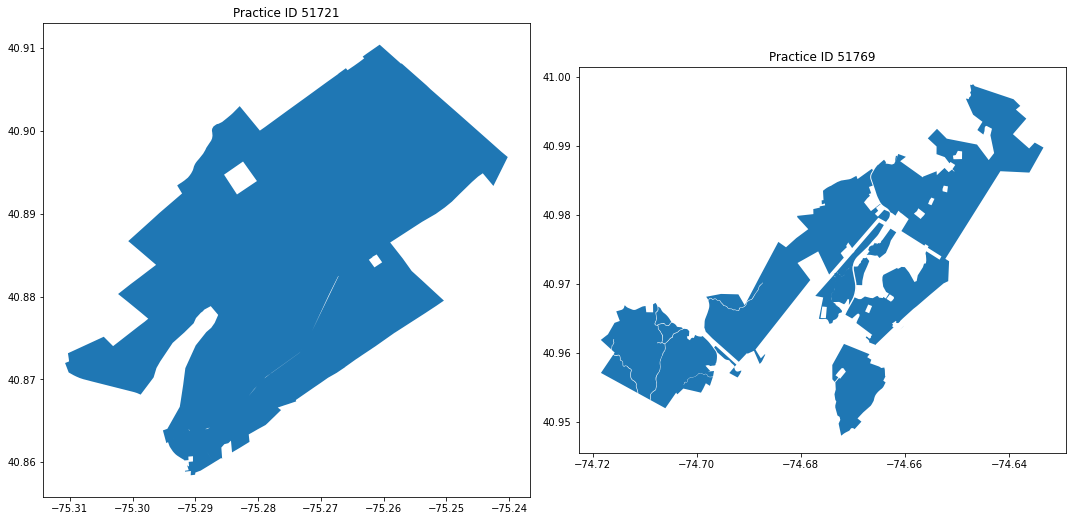

In [61]:
# Practice ID 51721 and 51769 were skipped 
x = fielddoc_gdf[fielddoc_gdf['practice_id']==51721]
y = fielddoc_gdf[fielddoc_gdf['practice_id']==51769]

fig, axes = plt.subplots(1,2, figsize=(15,15))

x.plot(ax=axes[0])
y.plot(ax=axes[1])

axes[0].set_title("Practice ID 51721")
axes[1].set_title("Practice ID 51769")

plt.tight_layout()

In [36]:
fd_lu_df.to_parquet('fd_naturalland.parquet', index=True, engine='pyarrow')

## WeConservePA

In [92]:
for item in wcpa1_json['features']:
    if 'OBJECTID' in wcpa1_json['features'][0]['properties']:
                name = item['properties']['OBJECTID']
                area = item['properties']['gis_acres']  

In [94]:
area

133.969773058

In [ ]:
wcpa1_lu_df = get_3030(wcpa1_json)

Finished: 1
Finished: 2
Finished: 3
Finished: 4
Finished: 5
Finished: 6
Finished: 7
Finished: 8
Finished: 9
Finished: 10
Finished: 11
Finished: 12
Finished: 13
Finished: 14
Finished: 15
Finished: 16
Finished: 17
Finished: 18
Finished: 19
Finished: 20
Finished: 21
Finished: 22
Finished: 23
Finished: 24
Finished: 25
Finished: 26
Finished: 27
Finished: 28
Finished: 29
Finished: 30
Finished: 31
Finished: 32
Finished: 33
Finished: 34
Finished: 35
Finished: 36
Finished: 37
Finished: 38
Finished: 39
Finished: 40
Finished: 41
Finished: 42
Finished: 43
Finished: 44
Finished: 45
Finished: 46
Finished: 47
Finished: 48
Finished: 49
Finished: 50
Finished: 51
Finished: 52
Finished: 53
***SKIPPED: 54***
Finished: 55
Finished: 56
Finished: 57
Finished: 58
Finished: 59
Finished: 60
Finished: 61
Finished: 62
Finished: 63
Finished: 64
Finished: 65
Finished: 66
Finished: 67
Finished: 68
Finished: 69
Finished: 70
Finished: 71
Finished: 72
Finished: 73
Finished: 74
Finished: 75
Finished: 76
Finished: 77
Fin